# 2 mm Tungsten Carbide Sphere Target Strength Validation

This notebook validates the target strength calculations for a 2 mm diameter tungsten carbide (WC) solid sphere across a frequency range of 1-1250 kHz.

## Validation Parameters
- **Sphere diameter**: 2.0 mm (radius = 1.0 mm)
- **Material**: Tungsten Carbide (WC)
- **Frequency range**: 1 - 1250 kHz
- **Number of points**: 4000
- **Environmental conditions**:
  - Temperature: 10°C
  - Salinity: 35 PSU
  - Depth: 30 m

## Import Required Libraries

Import necessary libraries including NumPy, Matplotlib, SciPy, and acoustic scattering libraries.

In [42]:
# Standard scientific computing imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add project root to path for imports
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

# Import SeaEcho modules
from utils.SeaEcho_water import seawater
from utils.SeaEcho_solid_sphere import Tungsten_carbide

# Import solid sphere scattering model
from SolidSphere.models.SeaEcho_TS_SolidSphere import TS_solid_sphere

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2


## Set Environmental Parameters

Define temperature (10°C), salinity (35 PSU), and depth (30 m) parameters and calculate corresponding seawater properties.

In [43]:
# Environmental parameters for seawater
T = 10.0    # Temperature (°C)
z = 30.0    # Depth (m)  
S = 35.0    # Salinity (psu)

# Create seawater object and get properties
water = seawater(T, z, S)
c_water = water.sound_speed()  # Sound speed in seawater
rho_water = water.density()    # Density of seawater


## Define Sphere Properties

Set up the 2 mm diameter tungsten carbide (WC) sphere properties including density, sound speed, and material parameters.

In [44]:
# Sphere parameters
sphere_diameter = 2.0e-3  # 2.0 mm diameter in meters
sphere_radius = sphere_diameter / 2

# Create tungsten carbide (WC) sphere object
sphere = Tungsten_carbide()


## Create Frequency Array

Generate a frequency array from 1 kHz to 1250 kHz with 4000 points using linear spacing for detailed analysis.

In [45]:
# Frequency range parameters
f_min = 1.0     # Minimum frequency (kHz)
f_max = 1250.0  # Maximum frequency (kHz)
n_points = 4000 # Number of frequency points

# Create linear frequency array
frequencies = np.linspace(f_min, f_max, n_points)  # kHz

# Calculate some useful parameters
wavelength_min = c_water / (f_max * 1000)  # Minimum wavelength (m)
wavelength_max = c_water / (f_min * 1000)  # Maximum wavelength (m)
ka_min = 2 * np.pi * sphere_radius / wavelength_max  # Minimum ka
ka_max = 2 * np.pi * sphere_radius / wavelength_min  # Maximum ka

print(f"Frequency Array Parameters:")
print(f"  Frequency range: {f_min:.1f} - {f_max:.1f} kHz")
print(f"  Number of points: {n_points}")
print(f"  Frequency resolution: {(f_max-f_min)/(n_points-1):.3f} kHz")

print(f"\nWavelength Range:")
print(f"  Maximum wavelength: {wavelength_max*1e3:.1f} mm (at {f_min:.1f} kHz)")
print(f"  Minimum wavelength: {wavelength_min*1e3:.2f} mm (at {f_max:.1f} kHz)")

print(f"\nDimensionless Parameter ka Range:")
print(f"  ka_min: {ka_min:.3f} (at {f_min:.1f} kHz)")
print(f"  ka_max: {ka_max:.1f} (at {f_max:.1f} kHz)")
print(f"  Sphere diameter/wavelength ratio: {sphere_diameter/wavelength_min:.1f} (at max freq)")


Frequency Array Parameters:
  Frequency range: 1.0 - 1250.0 kHz
  Number of points: 4000
  Frequency resolution: 0.312 kHz

Wavelength Range:
  Maximum wavelength: 1490.5 mm (at 1.0 kHz)
  Minimum wavelength: 1.19 mm (at 1250.0 kHz)

Dimensionless Parameter ka Range:
  ka_min: 0.004 (at 1.0 kHz)
  ka_max: 5.3 (at 1250.0 kHz)
  Sphere diameter/wavelength ratio: 1.7 (at max freq)


## Calculate Target Strength for Sphere

Calculate target strength using the solid sphere TS model for the elastic sphere.

In [46]:
# Initialize array for target strength results
TS = np.zeros(len(frequencies))

print("Calculating target strength for 2mm WC sphere using solid sphere TS model...")
print(f"Processing {len(frequencies)} frequency points from {f_min} to {f_max} kHz...")

# Calculate target strength for each frequency
for i, freq in enumerate(frequencies):
    try:
        # Calculate TS using solid sphere TS model
        # Function signature: TS_solid_sphere(f, a, sphere_material, water)
        TS[i] = TS_solid_sphere(freq, sphere_radius, sphere, water)
        
    except Exception as e:
        # If calculation fails, set to NaN
        TS[i] = np.nan
        if i % 1000 == 0:  # Only print occasional errors
            print(f"  Warning: Calculation failed for frequency {freq:.1f} kHz: {e}")
    
    # Progress indicator
    if (i + 1) % 800 == 0:
        progress = (i + 1) / len(frequencies) * 100
        print(f"  Progress: {progress:.1f}% ({i + 1}/{len(frequencies)} calculations)")

print("✓ Target strength calculations completed!")

# Calculate statistics
valid_count = np.sum(~np.isnan(TS))
success_rate = valid_count / len(TS) * 100
if valid_count > 0:
    ts_range = f"{np.nanmin(TS):.1f} to {np.nanmax(TS):.1f} dB"
    ts_mean = np.nanmean(TS)
else:
    ts_range = "No valid data"
    ts_mean = np.nan

print(f"\nCalculation Results:")
print(f"  Success rate: {valid_count}/{len(TS)} ({success_rate:.1f}%)")
print(f"  TS range: {ts_range}")
print(f"  Mean TS: {ts_mean:.1f} dB")
print(f"  Standard deviation: {np.nanstd(TS):.1f} dB")

Calculating target strength for 2mm WC sphere using solid sphere TS model...
Processing 4000 frequency points from 1.0 to 1250.0 kHz...
  Progress: 20.0% (800/4000 calculations)
  Progress: 40.0% (1600/4000 calculations)
  Progress: 60.0% (2400/4000 calculations)
  Progress: 80.0% (3200/4000 calculations)
  Progress: 100.0% (4000/4000 calculations)
✓ Target strength calculations completed!

Calculation Results:
  Success rate: 4000/4000 (100.0%)
  TS range: -156.8 to -65.3 dB
  Mean TS: -69.4 dB
  Standard deviation: 8.6 dB


## Calculate Moving Average of TS

Apply a moving average filter using 1% of the data window (40 points) to smooth the TS curve.

In [47]:
# Calculate moving average using 1% of data window
window_size = int(0.01 * n_points)  # 1% of 4000 = 40 points

# Apply moving average using convolution
def moving_average(data, window):
    """Calculate moving average using convolution"""
    # Create uniform kernel
    kernel = np.ones(window) / window
    # Apply convolution with 'valid' mode to avoid edge effects
    return np.convolve(data, kernel, mode='valid')

# Calculate moving average for TS data
TS_smoothed = moving_average(TS, window_size)

# Adjust frequency array to match smoothed data length
# (convolution with 'valid' mode reduces array size)
freq_smoothed = frequencies[window_size//2:-(window_size//2)]

# Fix the frequency array to match smoothed data exactly
freq_smoothed_fixed = frequencies[window_size//2:len(frequencies)-window_size//2+1][:len(TS_smoothed)]

# Calculate statistics for smoothed data
if len(TS_smoothed) > 0:
    ts_smooth_range = f"{np.nanmin(TS_smoothed):.1f} to {np.nanmax(TS_smoothed):.1f} dB"
    ts_smooth_mean = np.nanmean(TS_smoothed)
    ts_smooth_std = np.nanstd(TS_smoothed)
    

## Target Strength Values at Specific Frequencies

Extract and display TS values (original and smoothed) at key frequencies for analysis.

In [48]:
# Define specific frequencies of interest (kHz)
target_frequencies = [18, 38, 120, 200, 1000]

print("Target Strength Values at Specific Frequencies:")
print("=" * 55)
print(f"{'Frequency':<12} {'Original TS':<15} {'Smoothed TS':<15}")
print(f"{'(kHz)':<12} {'(dB)':<15} {'(dB)':<15}")
print("-" * 55)

for target_freq in target_frequencies:
    # Find the closest frequency index in the original data
    freq_diff = np.abs(frequencies - target_freq)
    closest_idx = np.argmin(freq_diff)
    actual_freq = frequencies[closest_idx]
    original_ts = TS[closest_idx]
    
    # Find the closest frequency index in the smoothed data
    freq_diff_smooth = np.abs(freq_smoothed_fixed - target_freq)
    closest_idx_smooth = np.argmin(freq_diff_smooth)
    actual_freq_smooth = freq_smoothed_fixed[closest_idx_smooth]
    smoothed_ts = TS_smoothed[closest_idx_smooth]
    
    print(f"{target_freq:<12.0f} {original_ts:<15.1f} {smoothed_ts:<15.1f}")

print("-" * 55)
print(f"Note: Values extracted from closest available frequencies in the data arrays.")
print(f"Frequency resolution: {(f_max-f_min)/(n_points-1):.3f} kHz")

Target Strength Values at Specific Frequencies:
Frequency    Original TS     Smoothed TS    
(kHz)        (dB)            (dB)           
-------------------------------------------------------
18           -106.7          -107.2         
38           -93.8           -93.9          
120          -74.8           -74.8          
200          -68.2           -68.2          
1000         -67.6           -67.6          
-------------------------------------------------------
Note: Values extracted from closest available frequencies in the data arrays.
Frequency resolution: 0.312 kHz


## Compare Original and Smoothed TS

Create a comprehensive comparison plot showing both original and moving averaged TS curves with proper legends and annotations.

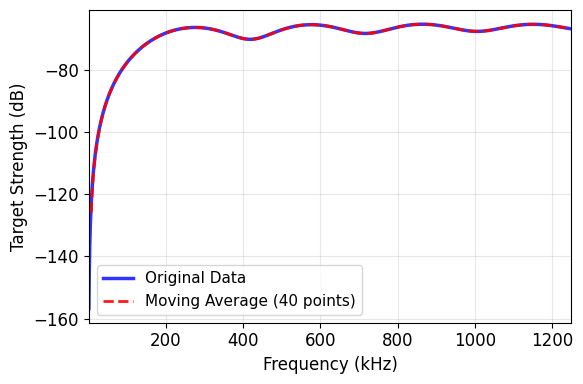

In [49]:
# Create comprehensive comparison plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Fix the frequency array to match smoothed data exactly
freq_smoothed_fixed = frequencies[window_size//2:len(frequencies)-window_size//2+1][:len(TS_smoothed)]

# Plot comparison
ax.plot(frequencies, TS, 'b-', linewidth=2.5, alpha=0.8, label='Original Data')
ax.plot(freq_smoothed_fixed, TS_smoothed, 'r--', linewidth=2, alpha=0.9, label=f'Moving Average ({window_size} points)')

ax.set_xlabel('Frequency (kHz)', fontsize=12)
ax.set_ylabel('Target Strength (dB)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
ax.set_xlim(f_min, f_max)

plt.tight_layout()
plt.show()


## Export Data to CSV

Save the calculated target strength data to a CSV file for further analysis.

In [50]:
import pandas as pd

# Create DataFrame with the target strength data
# For the smoothed data, we need to match the frequency arrays
data_dict = {
    'Frequency_kHz': frequencies,
    'TS_Original_dB': TS
}

# Create main DataFrame
df = pd.DataFrame(data_dict)

# Add smoothed data by interpolating to original frequency grid
# First create smoothed data DataFrame
df_smooth = pd.DataFrame({
    'Frequency_kHz': freq_smoothed_fixed,
    'TS_Smoothed_dB': TS_smoothed
})

# Merge with original data to align frequencies
df = df.merge(df_smooth, on='Frequency_kHz', how='left')

# Add environmental and sphere parameters as metadata columns
df['Sphere_Diameter_mm'] = sphere_diameter * 1000  # Convert to mm
df['Temperature_C'] = T
df['Salinity_PSU'] = S
df['Depth_m'] = z
df['Sound_Speed_m_s'] = c_water

# Calculate ka for each frequency
df['ka'] = 2 * np.pi * sphere_radius / (c_water / (df['Frequency_kHz'] * 1000))

# Create output file path
output_file = PROJECT_ROOT / 'data' / 'wc_sphere_2mm_validation_results.csv'

# Save to CSV
df.to_csv(output_file, index=False, float_format='%.6f')
